<a href="https://colab.research.google.com/github/AnastasiyaRahulina/EDA_airbnb_spatial_analysis/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_EDA_%D1%81_%D0%BA%D0%B0%D1%80%D1%82%D0%B0%D0%BC%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import folium
from folium import plugins, branca
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.stats import linregress



#*Предварительная* обработка данных, поисковый анализ.

В качестве задания было предложено проанализировать данные о удовлетворенности постояльцев размешением в различных городах Европы. Датасет доступен в открытом доступе на https://zenodo.org.

Для анализа доступны следующие показатели:

realSum: the full price of accommodation for two people and two nights in EUR
room_type: the type of the accommodation
room_shared: dummy variable for shared rooms
room_private: dummy variable for private rooms
person_capacity: the maximum number of guests
host_is_superhost: dummy variable for superhost status
multi: dummy variable if the listing belongs to hosts with 2-4 offers
biz: dummy variable if the listing belongs to hosts with more than 4 offers
cleanliness_rating: cleanliness rating
guest_satisfaction_overall: overall rating of the listing
bedrooms: number of bedrooms (0 for studios)
dist: distance from city centre in km
metro_dist: distance from nearest metro station in km
attr_index: attraction index of the listing location
attr_index_norm: normalised attraction index (0-100)
rest_index: restaurant index of the listing location
attr_index_norm: normalised restaurant index (0-100)
lng: longitude of the listing location
lat: latitude of the listing location

Привлекательным оказалось наличие географических координат, кроторые можно использовать для пространственного анализа.

In [3]:
#объединение датасетов в один, новые колонки город(название), день недели(будний = 0, выходной = 1)
cities = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 'london', 'paris', 'rome', 'vienna']
df_cities = []
for city in cities:
    weekdays = pd.read_csv('/content/drive/MyDrive/airbnb/' + city + '_weekdays.csv', index_col=0)
    weekends = pd.read_csv('/content/drive/MyDrive/airbnb/' + city + '_weekends.csv', index_col=0)
    weekdays['day_of_week'] = 0
    weekends['day_of_week'] = 1
    weekdays['city'] = city.title()
    weekends['city'] = city.title()
    df_cities.append(weekdays)
    df_cities.append(weekends)
city_total = pd.concat(df_cities, ignore_index=True)

In [4]:
city_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  float64
 5   host_is_superhost           51707 non-null  bool   
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  float64
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  517

In [5]:
city_total = city_total.round({'realSum': 2, 'dist': 3, 'metro_dist': 3, 'attr_index': 2, 'attr_index_norm': 2, 'rest_index': 2, 'rest_index_norm': 2})

In [6]:
# кол-во дубликатов
city_total.duplicated().sum()

40

In [7]:
city_total.drop_duplicates()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,day_of_week,city
0,194.03,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.023,2.539,78.69,4.17,98.25,6.85,4.90569,52.41772,0,Amsterdam
1,344.25,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488,0.239,631.18,33.42,837.28,58.34,4.90005,52.37432,0,Amsterdam
2,264.10,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748,3.652,75.28,3.99,95.39,6.65,4.97512,52.36103,0,Amsterdam
3,433.53,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.385,0.440,493.27,26.12,875.03,60.97,4.89417,52.37663,0,Amsterdam
4,485.55,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.545,0.319,552.83,29.27,815.31,56.81,4.90051,52.37508,0,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,715.94,Entire home/apt,False,False,6.0,False,0,1,10.0,100.0,...,0.530,0.135,219.40,15.71,438.76,10.60,16.37940,48.21136,1,Vienna
51703,304.79,Entire home/apt,False,False,2.0,False,0,0,8.0,86.0,...,0.810,0.101,204.97,14.68,342.18,8.27,16.38070,48.20296,1,Vienna
51704,637.17,Entire home/apt,False,False,2.0,False,0,0,10.0,93.0,...,0.994,0.203,169.07,12.11,282.30,6.82,16.38568,48.20460,1,Vienna
51705,301.05,Private room,False,True,2.0,False,0,0,10.0,87.0,...,3.044,0.287,109.24,7.82,158.56,3.83,16.34100,48.19200,1,Vienna


In [8]:
city_total.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
day_of_week                     int64
city                           object
dtype: object

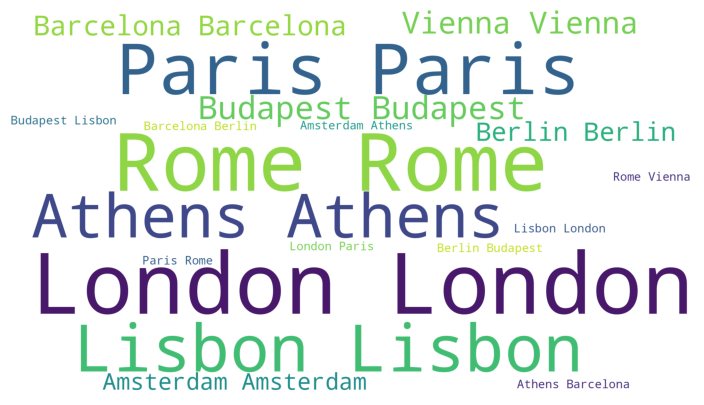

In [55]:
plt.subplots(figsize=(10,5))
wordcloud = WordCloud(background_color='white',
                      width=1920,
                      height=1080
                      ).generate(" ".join(city_total.city))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('city.png')
plt.show()
# Визуализация отражает какие города больше всего представлены в датасете

<ipython-input-11-d2a00cbf2322>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = city_total.corr(method='pearson')


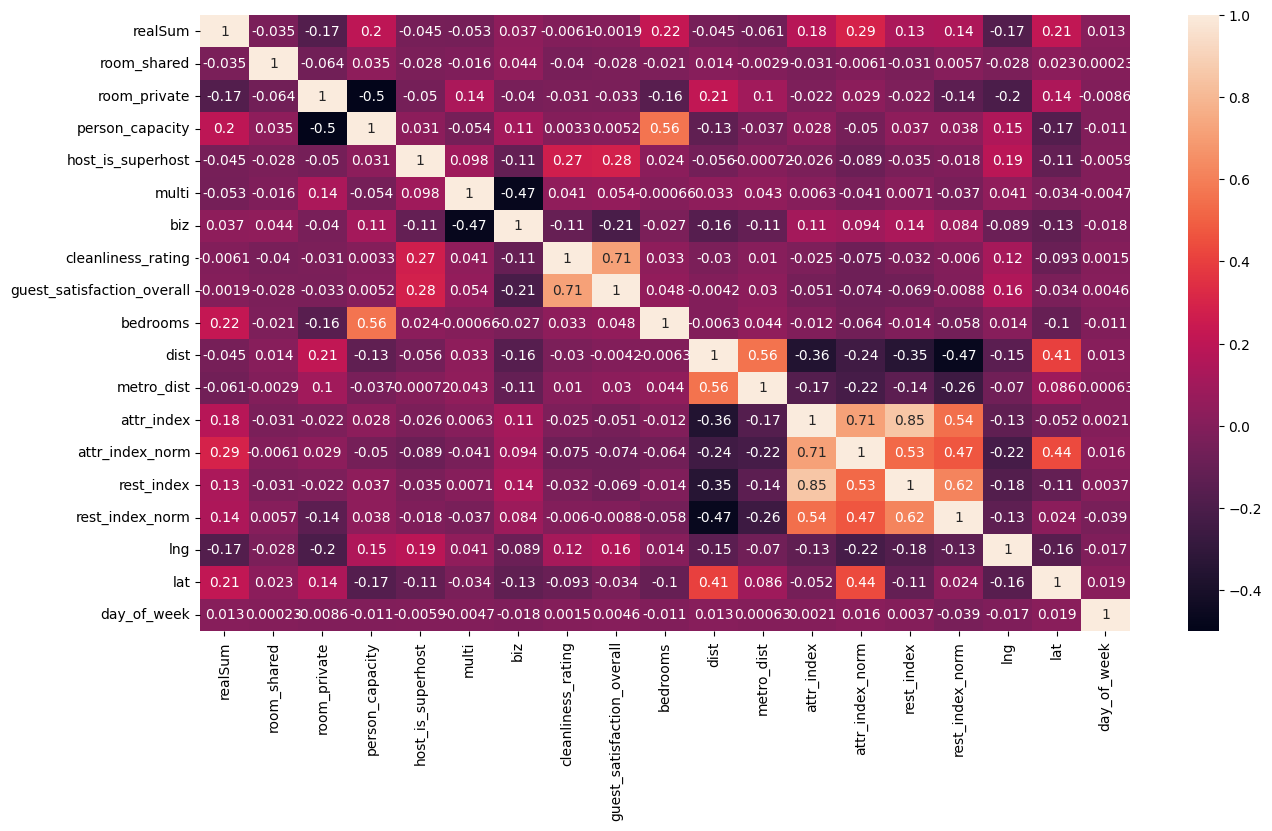

In [11]:
corr = city_total.corr(method='pearson')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
city_total.columns
plt.show()

#корелляция, видно, что в основно кореллируют показатели удовлетворенности и сводные индексы

<Axes: xlabel='realSum', ylabel='city'>

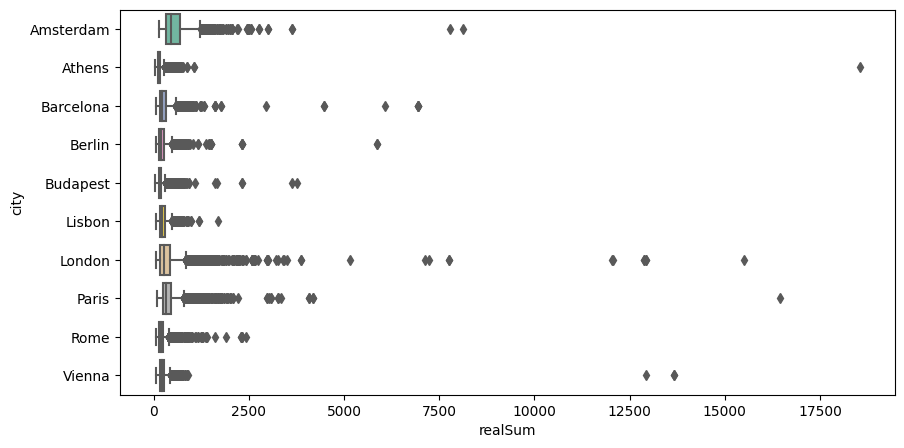

In [12]:
plt.figure(figsize = (10,5))
sns.boxplot(y = "city", x = "realSum", data = city_total, palette="Set2")
#у переменной realSum есть выбросы, которые могут затруднять анализ

In [13]:
city_cost = city_total.groupby('city')['realSum'].agg(['mean', 'median'])
city_cost
#поиск самых дорогих городов для проживания

,mean,median
city,,
Amsterdam,573.112740,460.245
Athens,151.744140,127.720
Barcelona,293.753276,208.300
Berlin,244.583712,191.180
Budapest,176.513906,152.980
Lisbon,238.210526,225.380
London,362.469262,261.290
Paris,392.531687,317.600
Rome,205.391990,182.590


Видно, что медиана и среднее сильно различаются, необходимо провести работу над выбросами.

#Работа с выбросами

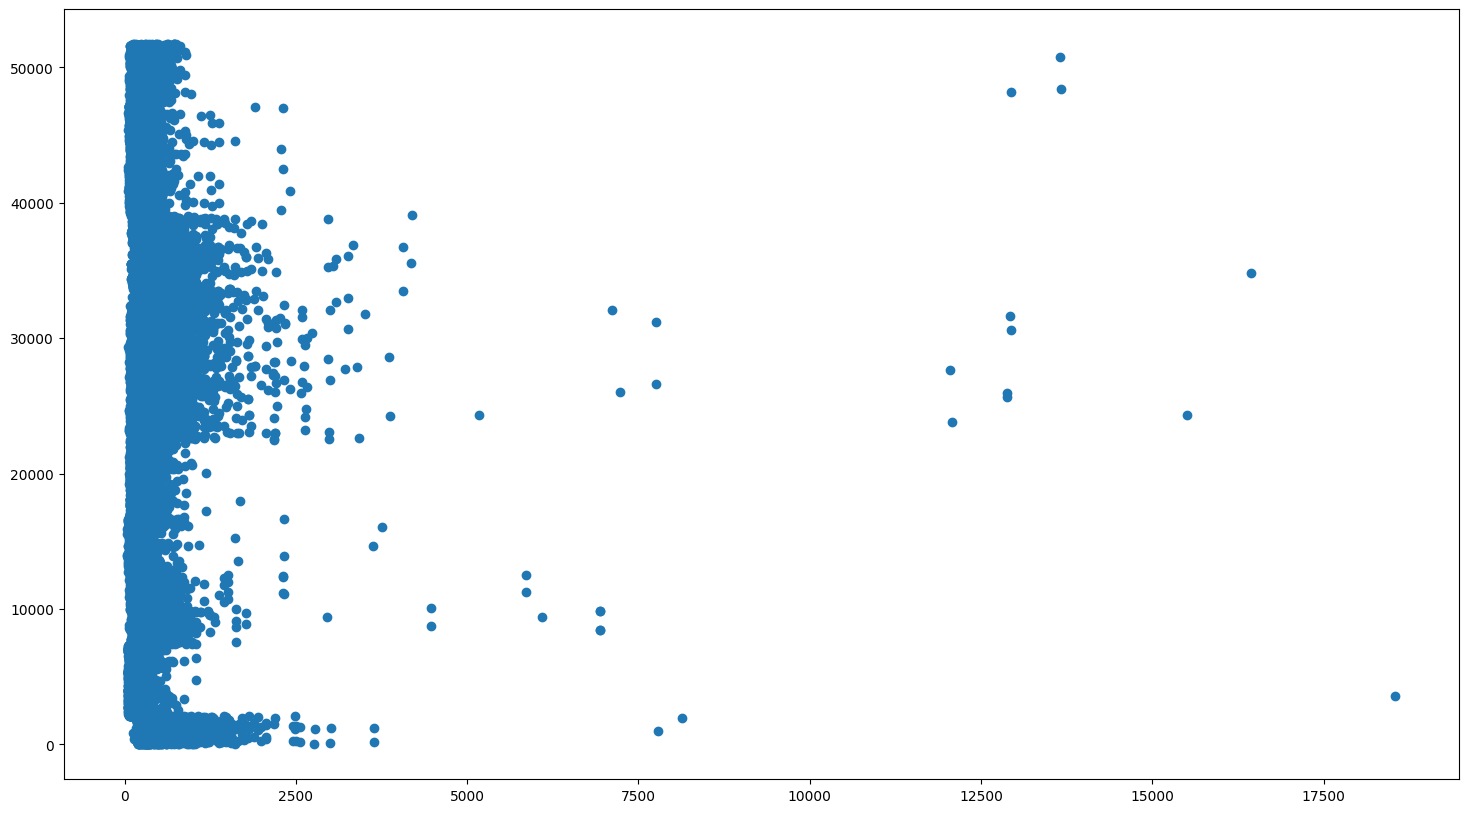

In [15]:
fig, ax = plt.subplots(figsize = (18, 10))
ax.scatter(city_total['realSum'],  city_total.index)

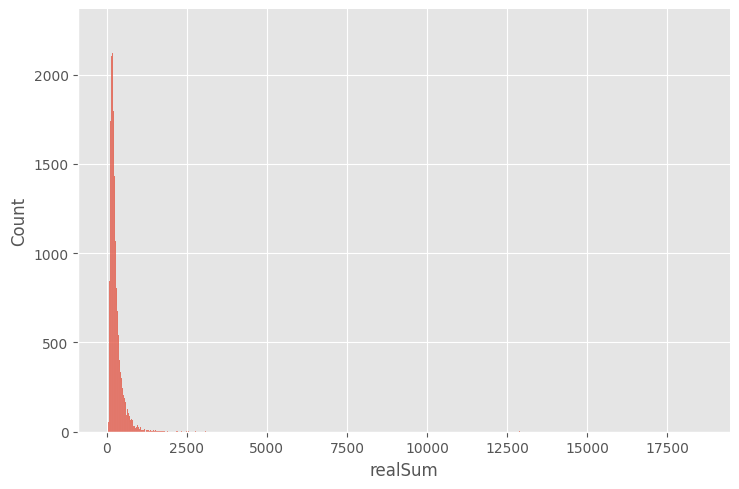

In [34]:
sns.displot(data=city_total, x="realSum", kind="hist", aspect=1.5)


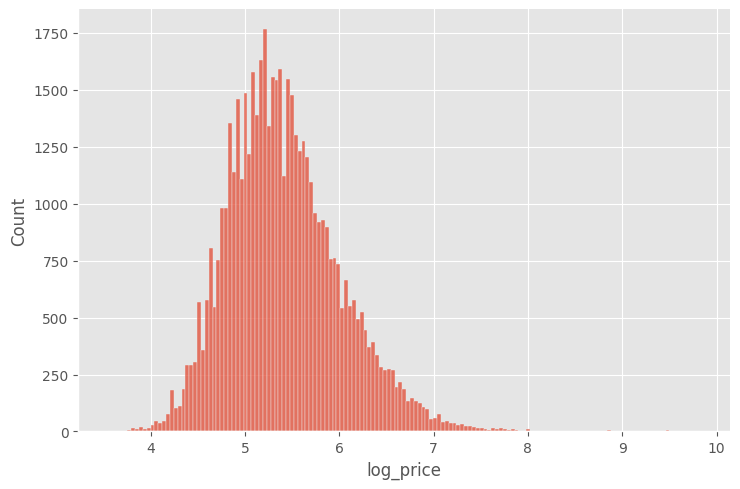

In [35]:
city_total = city_total[city_total.realSum!=0]
city_total.loc[:,"log_price"] = np.log(city_total.loc[:,"realSum"])
sns.displot(data=city_total, x="log_price", kind="hist", aspect=1.5)

<Axes: xlabel='log_price', ylabel='city'>

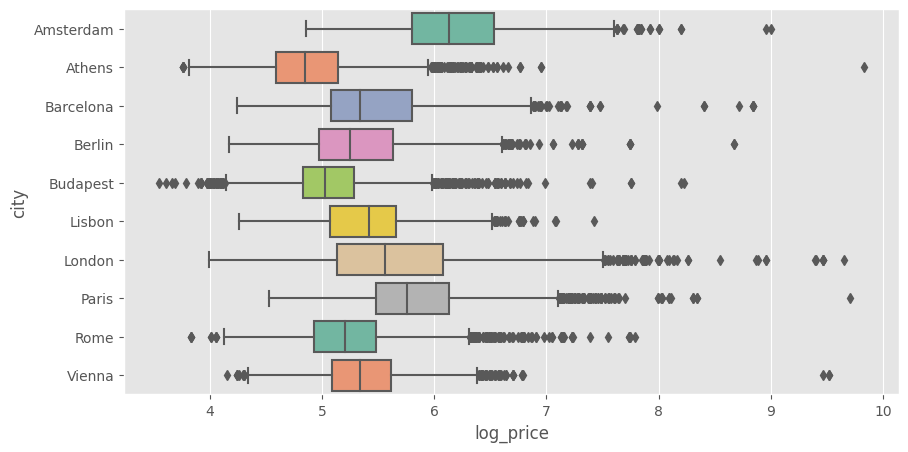

In [36]:
plt.figure(figsize = (10,5))
sns.boxplot(y = "city", x = "log_price", data = city_total, palette="Set2")
#разброс оценок, есть и плохие, лондон самый неоднозначный

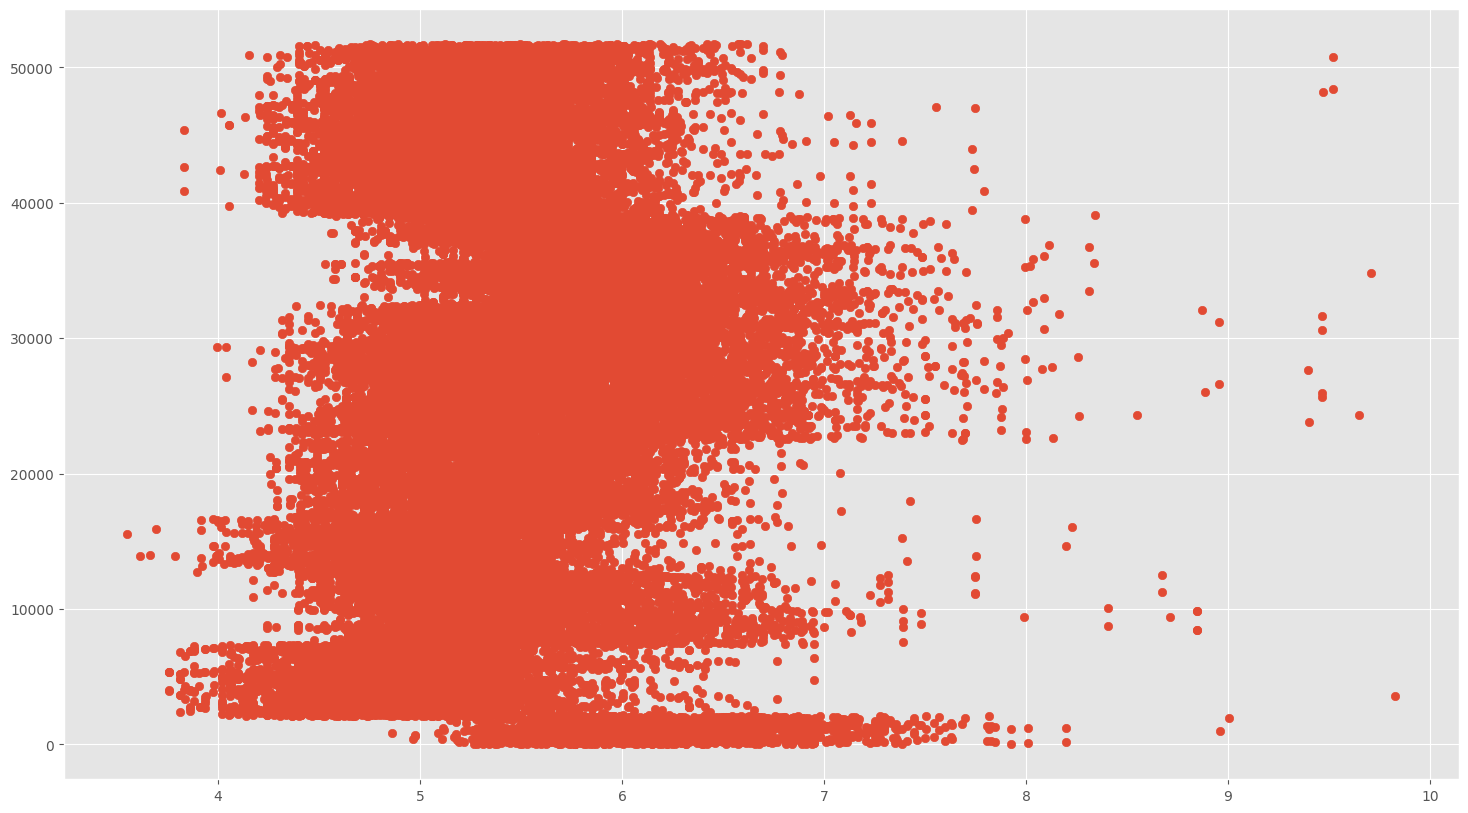

In [37]:
fig, ax = plt.subplots(figsize = (18, 10))
ax.scatter(city_total['log_price'],  city_total.index)

In [38]:
city_total[['log_price', 'guest_satisfaction_overall']].corr()
# корреляция между стоимостью и рейтингом слабая, отрицательная - как правило чем больше сумма, тем рейтинг незначительно ниже

,log_price,guest_satisfaction_overall
log_price,1.000000,-0.013133
guest_satisfaction_overall,-0.013133,1.000000


Гипотеза привлекательность района размещения повышает стоимость размещения



In [40]:
# корреляция между стоимостью и привлекательностью местоположения, умеренная, более высокая привлекательность местоположения увеличивает стоимость проживания
# имеет прогностическую ценность
city_total[['log_price', 'attr_index_norm']].corr()

,log_price,attr_index_norm
log_price,1.00000,0.46387
attr_index_norm,0.46387,1.00000


#Гипотеза: цены на размещение выше в местах, близких к самым порулярным достопримечательностям

Идея была ы том, чтобы раместить на карте города 5 основных достопримечательностей (в нашем случае в качестве референса взят рейтинг TripAdvisor) поверх heatmap со стоимостью размещения

In [44]:
#анализ проводился по отдельным городам с визуализацией на картах
paris = pd.read_csv("/content/drive/MyDrive/airbnb/paris_weekends.csv")
paris

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,536.396682,Entire home/apt,False,False,5.0,False,0,1,9.0,89.0,1,1.351201,0.212346,390.776775,19.001549,1030.738507,47.550371,2.35900,48.86800
1,1,290.101594,Private room,False,True,2.0,True,0,0,10.0,97.0,1,0.699821,0.193710,518.478270,25.211044,1218.658866,56.219575,2.35385,48.86282
2,2,445.754497,Entire home/apt,False,False,4.0,False,0,1,10.0,100.0,1,0.968982,0.294343,432.689942,21.039580,1069.894793,49.356741,2.36023,48.86375
3,3,211.343089,Private room,False,True,2.0,False,0,0,10.0,94.0,1,3.302319,0.234740,444.555284,21.616533,902.856370,41.650870,2.31714,48.87475
4,4,266.334234,Entire home/apt,False,False,2.0,True,0,0,9.0,88.0,1,1.402430,0.055052,1013.458689,49.279502,1348.063511,62.189313,2.33408,48.85384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,3553,295.460900,Entire home/apt,False,False,4.0,False,0,0,9.0,80.0,1,3.660389,0.168146,209.752453,10.199228,540.326583,24.926525,2.38051,48.88393
3554,3554,232.081275,Entire home/apt,False,False,4.0,False,0,0,10.0,98.0,1,3.558813,0.154703,185.486701,9.019304,474.351813,21.882955,2.40050,48.85093
3555,3555,223.925809,Entire home/apt,False,False,2.0,False,1,0,9.0,89.0,1,4.205205,0.253029,172.658919,8.395552,406.585935,18.756757,2.40100,48.87700
3556,3556,200.857489,Entire home/apt,False,False,2.0,True,0,0,9.0,93.0,1,2.891214,0.240674,235.167925,11.435057,602.451672,27.792500,2.38200,48.87400


<Axes: >

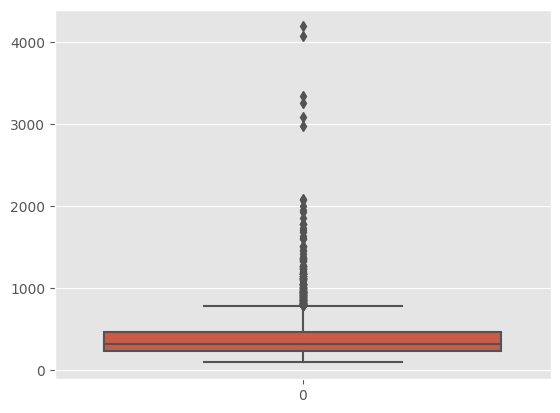

In [45]:
sns.boxplot(paris['realSum'])
#для корректного отображениея на heatmap следует оценить датасет на наличие выбросов

In [46]:
print(np.where(paris['realSum']>2000))

(array([ 256,  266,  498,  721, 1160, 1299, 2878, 3196, 3507]),)


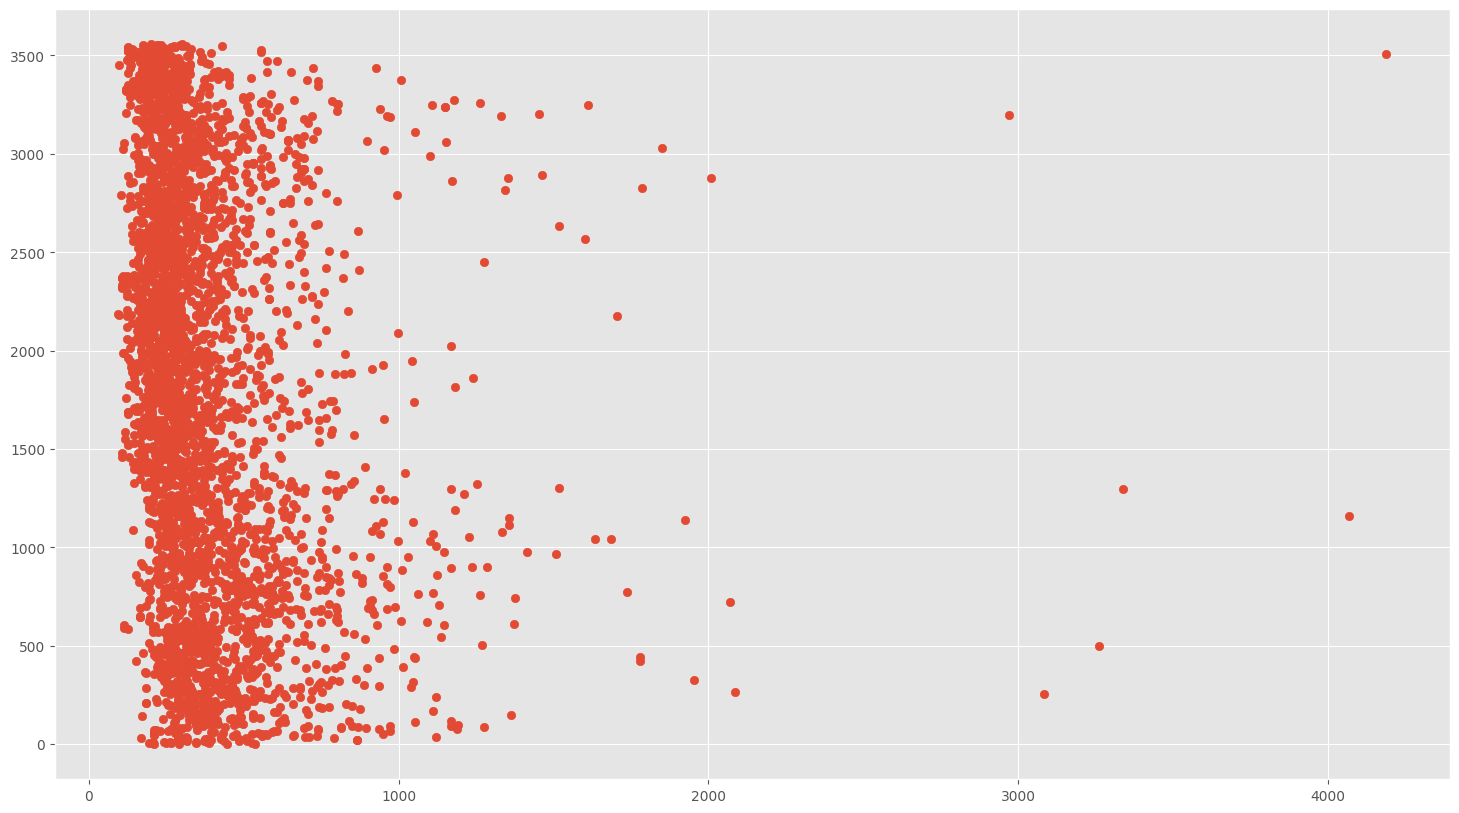

In [47]:
fig, ax = plt.subplots(figsize = (18, 10))
ax.scatter(paris['realSum'],  paris['Unnamed: 0'])

In [48]:
paris_clean = paris.copy()

In [49]:
def remove_outlier(col, df):
  Q1 = np.percentile(col, 25)
  Q3 = np.percentile(col, 75)
  IQR = Q3-Q1
  upper = Q3 + 1.5*IQR
  lower = Q1 - 1.5*IQR
  upper_outlier = np.where(col>=upper)
  lower_outlier = np.where(col<=lower)
  df.drop(upper_outlier[0], inplace=True)
  df.drop(lower_outlier[0], inplace=True)
  return df

#функция, удаляющая выбросы из датасета

remove_outlier(paris_clean['realSum'], paris_clean)
# paris_clean


,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,536.396682,Entire home/apt,False,False,5.0,False,0,1,9.0,89.0,1,1.351201,0.212346,390.776775,19.001549,1030.738507,47.550371,2.35900,48.86800
1,1,290.101594,Private room,False,True,2.0,True,0,0,10.0,97.0,1,0.699821,0.193710,518.478270,25.211044,1218.658866,56.219575,2.35385,48.86282
2,2,445.754497,Entire home/apt,False,False,4.0,False,0,1,10.0,100.0,1,0.968982,0.294343,432.689942,21.039580,1069.894793,49.356741,2.36023,48.86375
3,3,211.343089,Private room,False,True,2.0,False,0,0,10.0,94.0,1,3.302319,0.234740,444.555284,21.616533,902.856370,41.650870,2.31714,48.87475
4,4,266.334234,Entire home/apt,False,False,2.0,True,0,0,9.0,88.0,1,1.402430,0.055052,1013.458689,49.279502,1348.063511,62.189313,2.33408,48.85384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,3553,295.460900,Entire home/apt,False,False,4.0,False,0,0,9.0,80.0,1,3.660389,0.168146,209.752453,10.199228,540.326583,24.926525,2.38051,48.88393
3554,3554,232.081275,Entire home/apt,False,False,4.0,False,0,0,10.0,98.0,1,3.558813,0.154703,185.486701,9.019304,474.351813,21.882955,2.40050,48.85093
3555,3555,223.925809,Entire home/apt,False,False,2.0,False,1,0,9.0,89.0,1,4.205205,0.253029,172.658919,8.395552,406.585935,18.756757,2.40100,48.87700
3556,3556,200.857489,Entire home/apt,False,False,2.0,True,0,0,9.0,93.0,1,2.891214,0.240674,235.167925,11.435057,602.451672,27.792500,2.38200,48.87400


In [50]:
paris_clean.describe()

,Unnamed: 0,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000
mean,1807.318978,343.686493,2.866053,0.212355,0.229284,9.252747,92.043956,0.923968,3.010066,0.226996,369.494687,17.966706,812.165066,37.467068,2.343342,48.864485
std,1020.541294,146.992101,1.130334,0.409036,0.420435,0.973187,8.735016,0.594222,1.444345,0.122526,156.611180,7.615230,280.057510,12.919706,0.033572,0.017613
min,0.000000,95.302451,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.071566,0.003220,116.297536,5.654976,258.674498,11.933258,2.247880,48.819940
25%,933.500000,236.974555,2.000000,0.000000,0.000000,9.000000,89.000000,1.000000,1.865620,0.141925,262.306131,12.754655,593.517803,27.380360,2.323000,48.851850
50%,1823.000000,307.111567,2.000000,0.000000,0.000000,9.000000,94.000000,1.000000,3.011489,0.207889,333.810459,16.231558,761.448772,35.127407,2.346750,48.866150
75%,2683.500000,422.919191,4.000000,0.000000,0.000000,10.000000,98.000000,1.000000,4.052268,0.290653,445.339064,21.654644,1022.674740,47.178370,2.367655,48.878390
max,3557.000000,788.051077,6.000000,1.000000,1.000000,10.000000,100.000000,5.000000,7.703733,1.154771,2056.552199,100.000000,2167.677121,100.000000,2.438590,48.901060


<Axes: >

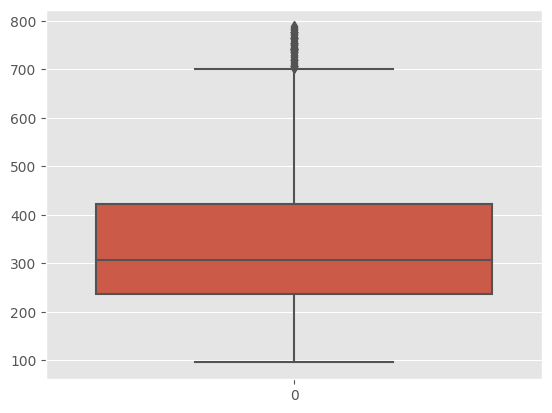

In [51]:
sns.boxplot(paris_clean['realSum'])


In [52]:
paris_loc = paris[["realSum", "lng", "lat"]]
realSum = paris_loc["realSum"]
lng = paris_loc["lng"]
lat = paris_loc["lat"]


In [ ]:
#координаты самых популярных достопримечательностей Парижа по версии tripadvisor
paris_poi = pd.read_csv('/content/parispoi.txt')

In [ ]:
paris_map = folium.Map(location=[48.85,2.34], tiles="Cartodb Positron", zoom_start = 13)
for i in range(len(paris_poi)):
  folium.Marker(
      location = [paris_poi.iloc[i][1], paris_poi.iloc[i][2]],
      popup = paris_poi.iloc[i][0],
      icon=folium.Icon(color="red", icon="info-sign")
      ).add_to(paris_map)
paris_map


In [ ]:
heat_data = [[lat, lng, price] for lat, lng, price in zip(paris_loc['lat'], paris_loc['lng'], paris_loc['realSum'] )]

In [ ]:
plugins.HeatMap(heat_data, radius=10, min_opacity= 0.5).add_to(paris_map)
paris_map

In [54]:
paris_map = folium.Map(location=[48.85,2.34], tiles="Cartodb Positron", zoom_start = 13)

heat_data_norm = [[lat, lng, price] for lat, lng, price in zip(paris_clean['lat'], paris_clean['lng'], paris_clean['realSum'] )]
plugins.HeatMap(heat_data_norm, radius=10, min_opacity= 0.5).add_to(paris_map)
paris_map

Вывод: глазом не видно явной зависимости стоимости от указанных локаций. Очистка датасета от выбросов также внешне незначительно поменяла результирующую карту

In [ ]:
amsterdam_weekends = pd.read_csv('/content/amsterdam_weekends.csv')

In [ ]:
amsterdam_weekends

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,319.640053,Private room,False,True,2.0,False,0,1,9.0,88.0,1,4.763360,0.852117,110.906123,5.871971,136.982208,11.941560,4.84639,52.34137
1,1,347.995219,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748310,3.651591,75.275937,3.985516,95.386468,8.315410,4.97512,52.36103
2,2,482.975183,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384872,0.439852,493.272517,26.116521,875.114817,76.289005,4.89417,52.37663
3,3,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544723,0.318688,552.849514,29.270850,815.303994,71.074937,4.90051,52.37508
4,4,2771.541724,Entire home/apt,False,False,4.0,True,0,0,10.0,100.0,3,1.686798,1.458399,208.809162,11.055489,272.315202,23.739349,4.88467,52.38749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,972,473.132894,Entire home/apt,False,False,2.0,False,0,0,9.0,98.0,0,1.911795,1.723938,283.762206,15.023909,351.969002,30.683248,4.86742,52.36629
973,973,491.645771,Entire home/apt,False,False,3.0,False,0,0,10.0,98.0,2,1.478016,1.465641,241.418512,12.782005,312.785000,27.267344,4.88066,52.38412
974,974,1812.855904,Entire home/apt,False,False,4.0,False,0,0,8.0,84.0,5,1.943031,0.388542,257.946814,13.657103,336.589450,29.342520,4.90688,52.35794
975,975,399.315727,Entire home/apt,False,False,2.0,False,0,0,9.0,89.0,1,3.719001,0.882094,156.045916,8.261917,189.962216,16.560145,4.86056,52.34639


In [ ]:
amsterdam_weekends.describe()

,Unnamed: 0,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000
mean,488.000000,604.828018,2.769703,0.254862,0.094166,9.470829,94.685773,1.302968,2.806345,1.089285,266.868700,14.129476,329.132787,28.692478,4.889697,52.364387
std,282.179907,443.682821,1.019876,0.436007,0.292209,0.830649,6.632364,0.732949,2.036602,0.826555,193.156767,10.226766,214.384885,18.689216,0.038575,0.018213
min,0.000000,165.912872,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.015045,0.036517,40.890060,2.164941,50.823991,4.430632,4.775950,52.290310
25%,244.000000,362.758653,2.000000,0.000000,0.000000,9.000000,93.000000,1.000000,1.410043,0.467145,132.719465,7.026888,170.682205,14.879391,4.869240,52.354550
50%,488.000000,491.645771,2.000000,0.000000,0.000000,10.000000,96.000000,1.000000,2.314549,0.876169,208.904591,11.060542,266.956967,23.272239,4.888100,52.365180
75%,732.000000,716.612378,4.000000,1.000000,0.000000,10.000000,99.000000,2.000000,3.610169,1.500856,366.687247,19.414411,438.109342,38.192618,4.906240,52.375250
max,976.000000,8130.668104,6.000000,1.000000,1.000000,10.000000,100.000000,5.000000,11.195932,4.411905,1888.737455,100.000000,1147.104769,100.000000,5.010770,52.415380


<Axes: >

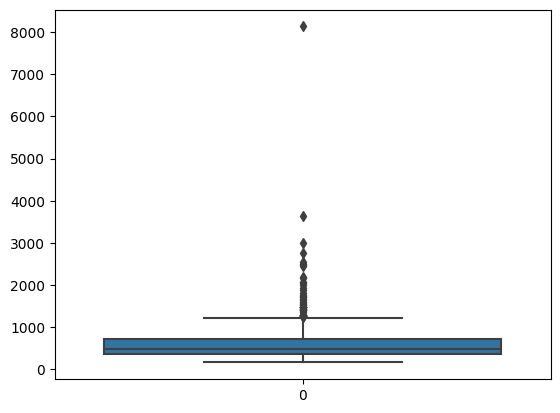

In [ ]:
sns.boxplot(data=amsterdam_weekends['realSum'])


<Axes: xlabel='realSum', ylabel='Count'>

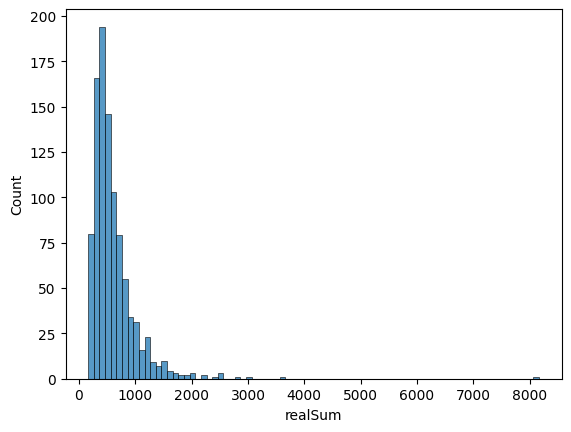

In [ ]:
sns.histplot(amsterdam_weekends['realSum'], binwidth=100)


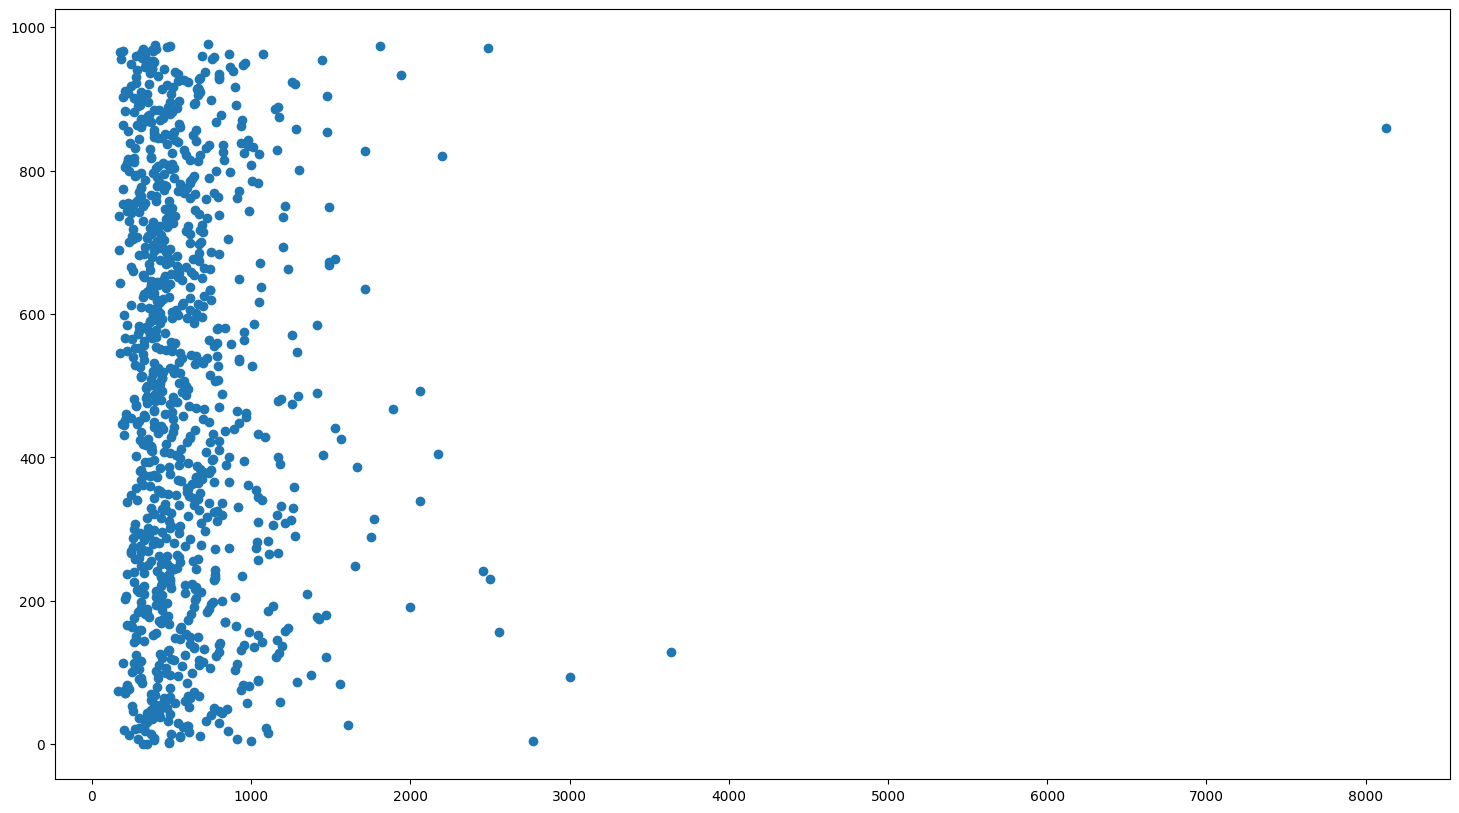

In [ ]:
fig, ax = plt.subplots(figsize = (18, 10))
ax.scatter(amsterdam_weekends['realSum'],  amsterdam_weekends['Unnamed: 0'])

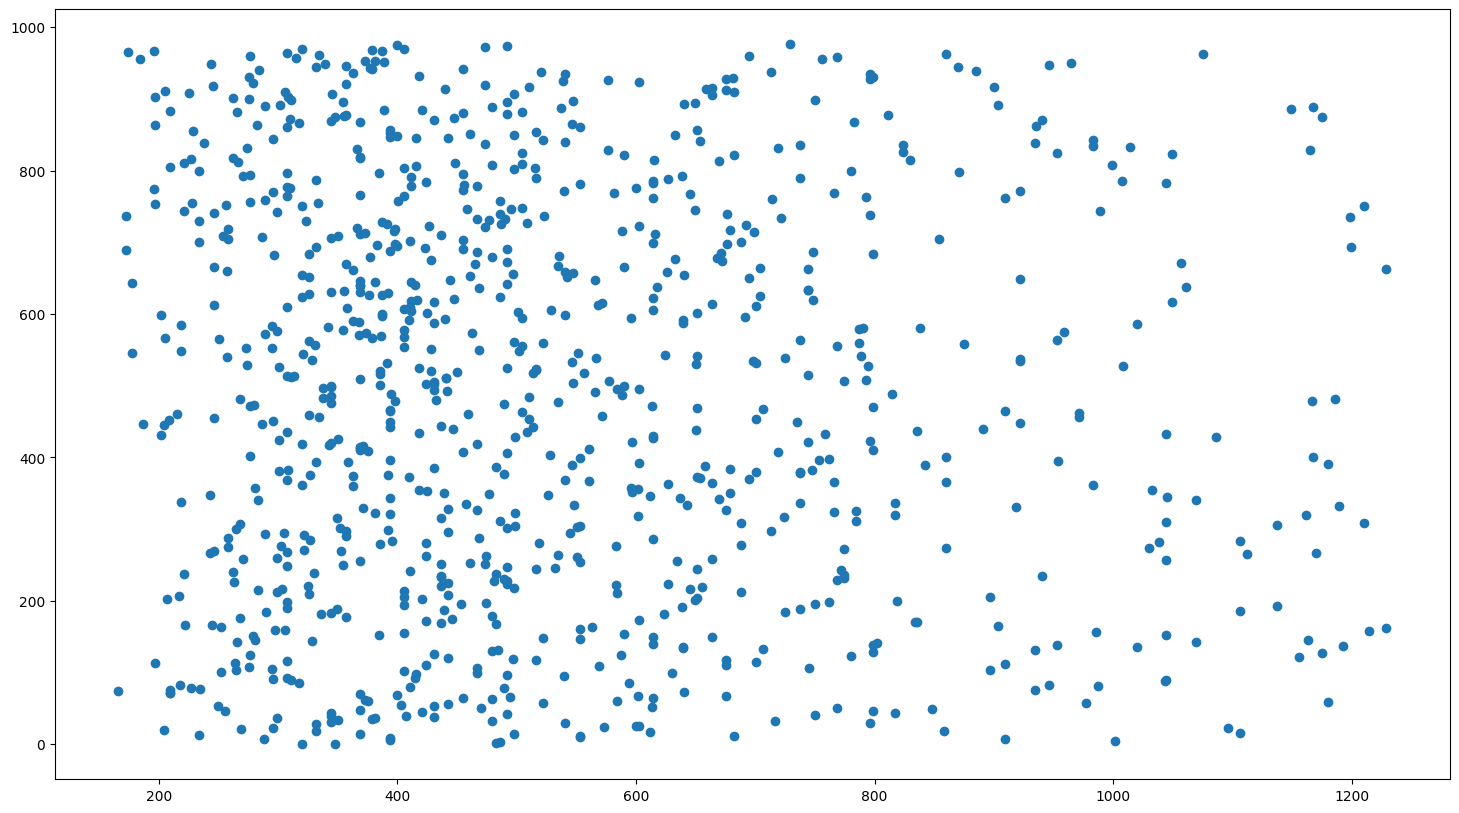

In [ ]:
fig, ax = plt.subplots(figsize = (18, 10))
ax.scatter(amsterdam_clean['realSum'],  amsterdam_clean['Unnamed: 0'])

In [ ]:
sns.boxplot(paris['realSum'])


In [ ]:
amsterdam_clean = amsterdam_weekends.copy()
remove_outlier(amsterdam_clean['realSum'], amsterdam_clean)
amsterdam_clean

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,319.640053,Private room,False,True,2.0,False,0,1,9.0,88.0,1,4.763360,0.852117,110.906123,5.871971,136.982208,11.941560,4.84639,52.34137
1,1,347.995219,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748310,3.651591,75.275937,3.985516,95.386468,8.315410,4.97512,52.36103
2,2,482.975183,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384872,0.439852,493.272517,26.116521,875.114817,76.289005,4.89417,52.37663
3,3,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544723,0.318688,552.849514,29.270850,815.303994,71.074937,4.90051,52.37508
5,5,1001.804420,Entire home/apt,False,False,4.0,False,0,0,9.0,96.0,2,3.719139,1.196104,106.226538,5.624209,133.876300,11.670800,4.86459,52.40175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,970,405.642912,Private room,False,True,4.0,True,0,0,10.0,95.0,1,2.169236,0.212117,224.435844,11.882850,291.789702,25.437058,4.91118,52.35718
972,972,473.132894,Entire home/apt,False,False,2.0,False,0,0,9.0,98.0,0,1.911795,1.723938,283.762206,15.023909,351.969002,30.683248,4.86742,52.36629
973,973,491.645771,Entire home/apt,False,False,3.0,False,0,0,10.0,98.0,2,1.478016,1.465641,241.418512,12.782005,312.785000,27.267344,4.88066,52.38412
975,975,399.315727,Entire home/apt,False,False,2.0,False,0,0,9.0,89.0,1,3.719001,0.882094,156.045916,8.261917,189.962216,16.560145,4.86056,52.34639


In [ ]:
amsterdam_poi = pd.read_csv("/content/poi_amsterdam.txt")
amsterdam_poi

,Location,lat,lng
0,Rijksmuseum,52.360000,4.885278
1,AnneFrankHuis,52.375580,4.884400
2,VanGoghMuseum,52.358417,4.881083
3,Vondelpark,52.358000,4.868000
4,CentraalStation,52.378282,4.900314


In [ ]:
amsterdam_map = folium.Map(location=[52.37022, 4.89517], tiles="Cartodb Positron", zoom_start = 14)
for i in range(len(amsterdam_poi)):
  folium.CircleMarker(radius = 50,
      location = [amsterdam_poi.iloc[i][1], amsterdam_poi.iloc[i][2]],
      popup = amsterdam_poi.iloc[i][0],
      icon=folium.Icon(color="red", icon="info-sign")
      ).add_to(amsterdam_map)
amst_loc = amsterdam_weekends[["lng", "lat", "realSum"]]
heat_data = [[lat, lng, price] for lat, lng, price in zip(amst_loc['lat'], amst_loc['lng'], amst_loc['realSum'])]
plugins.HeatMap(heat_data, radius=15, min_opacity= 0.6).add_to(amsterdam_map)
amsterdam_map


In [ ]:
amsterdam_map = folium.Map(location=[52.37022, 4.89517], tiles="Cartodb Positron", zoom_start = 14)
for i in range(len(amsterdam_poi)):
  folium.CircleMarker(radius = 50,
      location = [amsterdam_poi.iloc[i][1], amsterdam_poi.iloc[i][2]],
      popup = amsterdam_poi.iloc[i][0],
      icon=folium.Icon(color="red", icon="info-sign")
      ).add_to(amsterdam_map)
amst_loc = amsterdam_clean[["lng", "lat", "realSum"]]
heat_data2 = [[lat, lng, price] for lat, lng, price in zip(amst_loc['lat'], amst_loc['lng'], amst_loc['realSum'])]
plugins.HeatMap(heat_data2, radius=15, min_opacity= 0.6).add_to(amsterdam_map)
amsterdam_map

In [ ]:
london_poi = pd.read_csv("/content/poi_london.txt")
london_weekends = pd.read_csv("/content/london_weekends.csv")

london_map = folium.Map(location=[51.50735, -0.12776], tiles="Cartodb Positron", zoom_start = 13)

for realSum, lng, lat in zip(london_poi['location'], london_poi['lng'], london_poi['lat']):
  folium.Marker(location=[lat, lng], popup=paris_poi['location'], icon=folium.Icon(color = 'gray')).add_to(london_map)

heat_data = [[lat, lng, price] for lat, lng, price in zip(london_weekends['lat'], london_weekends['lng'], london_weekends['realSum'])]

plugins.HeatMap(heat_data, radius=10, min_opacity= 0.6).add_to(london_map)
london_map

Вывод: внешне не заметно связи, однако, города очень большие, достопримечательностей много, в идеале, нужно учесть их все. Кроме того, на стоимость очевидно будут влиять и расположение станций метро, торговых центров.